# Task05_模型融合
<br>

* 模型融合是把强分类器进行强强联合，变得更强。
<br>

* 在进行模型融合的时候，也不是说随意的融合就能达到好的效果。进行融合时，所需的集成个体（就是用来集成的模型）应该好而不同。好指的是个体学习器的性能要好，不同指的是个体模型的类别不同。
<br>

* 这里举个西瓜书的例子，在介绍例子之前，首先提前介绍简单投票法，以分类问题为例，就是每个分类器对样例进行投票，哪个类别得到的票数最多的就是融合后模型的结果。
<br>

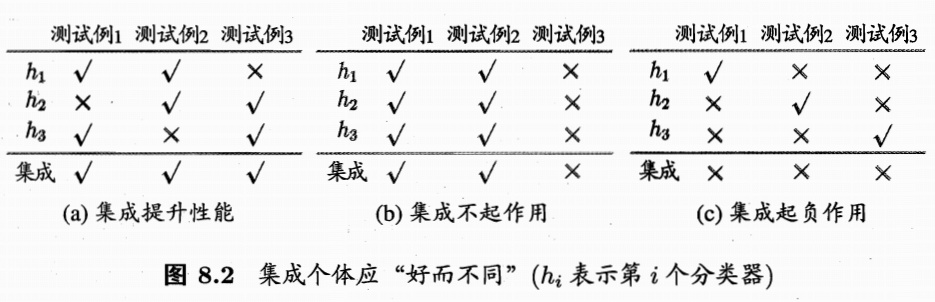

* 在上面的例子中，采用的就是简单的投票法。中间的图b各个模型输出都一样，因此没有什么效果。第三个图c每个分类器的精度只有33%，融合后反而更糟。也就是说，想要模型融合有效果，个体学习器要有一定的准确率，并且要有多样性，学习器之间具有差异，即”好而不同“。
<br>

* 如何做到好而不同呢？可以由下面几个方面：
<br>

* 针对输入数据：使用采样的方法得到不同的样本（比如bagging方法采用自助法进行抽样）
* 针对特征：对特征进行抽样
* 针对算法本身：<br>
    个体学习器 [公式] 来自不同的模型集合<br>
    个体学习器 [公式] 来自于同一个模型集合的不同超参数，例如学习率η不同<br>
    算法本身具有随机性，例如用不同的随机种子来得到不同的模型<br>
    针对输出：对输出表示进行操纵以增强多样性<br>
    如将多分类转化为多个二分类任务来训练单模型<br>
    将分类输出转化为回归输出等<br>


In [2]:
#导包 读数据
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import IsolationForest
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
X_train = pd.read_csv('train_clt.csv')
Y_train = pd.read_csv('Y_train.csv', names=['tradeMoney'])
X_test = pd.read_csv('test_clt.csv')        #读写清洗之后的测试数据

In [3]:
X_train.drop('Unnamed: 0', axis = 1, inplace = True)
X_train.head()

,area,buildYear,communityName,houseDecoration,houseFloor,houseToward,houseType,landMeanPrice,landTotalPrice,lookNum,...,landMeanPrice_buildYear_cluster_mean,totalWorkers_buildYear_cluster_mean,newWorkers_buildYear_cluster_mean,residentPopulation_buildYear_cluster_mean,lookNum_buildYear_cluster_mean,trainsportNum_buildYear_cluster_mean,all_SchoolNum_buildYear_cluster_mean,all_hospitalNum_buildYear_cluster_mean,all_mall_buildYear_cluster_mean,otherNum_buildYear_cluster_mean
0,68,1953,50,0,1,6,11,0.00000,0.000000,0,...,0.000000,193780.46150,7624.692308,241618.4615,3.538462,6.236289,3.650150,2.965824,1.498916,4.198884
1,125,2007,124,2,0,6,26,0.00000,0.000000,1,...,793.660477,47644.90991,4589.045045,301199.3423,1.939189,5.242404,3.497555,3.117721,1.822702,4.680017
2,132,1994,171,0,1,6,26,0.00000,0.000000,1,...,466.349398,60085.72716,2453.072094,345266.6986,1.295836,7.830420,3.672993,3.772766,2.412822,6.340365
3,57,1994,300,3,0,6,3,8.03302,19.622932,9,...,466.349398,60085.72716,2453.072094,345266.6986,1.295836,7.830420,3.672993,3.772766,2.412822,6.340365
4,129,1994,1201,1,1,6,27,0.00000,0.000000,0,...,466.349398,60085.72716,2453.072094,345266.6986,1.295836,7.830420,3.672993,3.772766,2.412822,6.340365


In [4]:
Y_train.head()

,tradeMoney
0,2000.0
1,2000.0
2,16000.0
3,1600.0
4,2900.0


In [6]:

X_test.drop('Unnamed: 0.1', axis = 1, inplace = True)
X_test.head()

,area,buildYear,communityName,houseDecoration,houseFloor,houseToward,houseType,landMeanPrice,landTotalPrice,lookNum,...,landMeanPrice_buildYear_cluster_mean,totalWorkers_buildYear_cluster_mean,newWorkers_buildYear_cluster_mean,residentPopulation_buildYear_cluster_mean,lookNum_buildYear_cluster_mean,trainsportNum_buildYear_cluster_mean,all_SchoolNum_buildYear_cluster_mean,all_hospitalNum_buildYear_cluster_mean,all_mall_buildYear_cluster_mean,otherNum_buildYear_cluster_mean
0,36,2008,2236,0,2,6,3,0.000000,0.000000,2,...,639.471274,51297.210643,4176.04878,330548.929047,1.643016,6.590703,3.105773,3.448993,2.137060,4.848183
1,64,2009,494,0,2,3,9,0.000000,0.000000,0,...,1151.993716,60453.126667,4366.84000,418350.346667,1.460000,7.970982,4.099660,4.095171,3.022181,7.728409
2,98,1996,512,3,2,4,15,0.000000,0.000000,0,...,121.256150,82016.201044,0.00000,268729.212794,0.000000,6.192685,4.713544,2.313740,1.722487,4.403485
3,43,1994,476,0,2,4,3,0.000000,0.000000,0,...,310.367031,55913.913911,0.00000,282518.344844,0.000000,5.543887,4.071482,2.682063,1.940299,4.484234
4,92,2004,770,0,2,4,11,8.420021,20.799106,0,...,299.642838,62222.941924,0.00000,338851.972777,0.000000,6.640213,4.522304,3.369698,2.175236,5.360881


## 单模预测
<br>

* 根据交叉验证和3折搜索得出的最佳参数，代入单模进行预测

In [13]:
param =  {
       'bagging_fraction': 0.8937422106459382,
       'bagging_freq': 11,
       'feature_fraction': 0.8002794768709935,
       'lambda_l1': 9.971220940988054,
       'lambda_l2': 9.682040437537356,
       'learning_rate': 0.00992362524397284,
       'max_bin': 192,
       'min_data_in_leaf': 37,
       'min_sum_hessian_in_leaf': 4.158069557774057,
       'num_leaves': 49,
}

def model_fit(features, labels, param):
    folds = KFold(n_splits=5, shuffle=True, random_state=2333)
#     print(features.head())
#     print(labels.head())
    "===================================第一轮========================================================"
    y_pre_list = []
    r2_list = []
    train_feat = pd.Series()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(features, labels)):
        print("fold {}".format(fold_+1))
#         print(features[val_idx].info())
#         print(labels[val_idx].info())
#         trn_data = lgb.Dataset(data=features.iloc[trn_idx], label=labels.iloc[trn_idx])
#         val_data = lgb.Dataset(data=features.iloc[val_idx], label=labels.iloc[val_idx])
#         print(trn_data)
#         print(val_data)
        trn_data = lgb.Dataset(features[trn_idx], labels[trn_idx])
        val_data = lgb.Dataset(features[val_idx], labels[val_idx])
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], early_stopping_rounds=200,
                        verbose_eval=500)
#         clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
        y_pre = clf.predict(features.iloc[val_idx], num_iteration=clf.best_iteration)
        r2 = r2_score(y_pre,labels.iloc[val_idx])
        r2_list.append(r2)
        train_feat = train_feat.append(pd.Series(y_pre,index=val_idx))
        y_pre_test = clf.predict(test,num_iteration=clf.best_iteration)
        y_pre_list.append(y_pre_test)
    print('r2 score{:}'.format(r2))
    print('r2:{:}'.format(np.mean(r2_list)))

    y_pred_final=  (y_pre_list[0]+y_pre_list[1]+y_pre_list[2]+y_pre_list[3]+y_pre_list[4])/5
    feature['pre'] = train_feat
    test['pre'] = y_pred_final
    "===================================第二轮========================================================"
    y_pre_list = []
    r2_list = []
    train_feat = pd.Series()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(features, labels)):
        print("fold {}".format(fold_+1))
        trn_data = lgb.Dataset(features.iloc[trn_idx], labels.iloc[trn_idx])
        val_data = lgb.Dataset(features.iloc[val_idx], labels.iloc[val_idx])
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, feval=get_r2_metric, valid_sets=[trn_data, val_data], verbose_eval=500,
                    early_stopping_rounds=200)
        y_pre = clf.predict(features.iloc[val_idx], num_iteration=clf.best_iteration)
        r2 = r2_score(y_pre,labels.iloc[val_idx])
        r2_list.append(r2)
        train_feat = train_feat.append(pd.Series(y_pre,index=val_idx))
        y_pre_test = clf.predict(test,num_iteration=clf.best_iteration)
        y_pre_list.append(y_pre_test)
    print('r2 score{:}'.format(r2))
    print('r2:{:}'.format(np.mean(r2_list)))
    
    y_pred_final=  (y_pre_list[0]+y_pre_list[1]+y_pre_list[2]+y_pre_list[3]+y_pre_list[4])/5
    feature['pre_2'] = train_feat
    test['pre_2'] = y_pred_final
    "=======================第三轮========================================================"
    y_pre_list = []
    r2_list = []
    train_feat = pd.Series()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(features, labels)):
        print("fold {}".format(fold_+1))
        trn_data = lgb.Dataset(features.iloc[trn_idx], labels.iloc[trn_idx])
        val_data = lgb.Dataset(features.iloc[val_idx], labels.iloc[val_idx])
        
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, feval=get_r2_metric,valid_sets=[trn_data, val_data], verbose_eval=500,
                    early_stopping_rounds=200)
        y_pre = clf.predict(features.iloc[val_idx], num_iteration=clf.best_iteration)
        r2 = r2_score(y_pre,labels.iloc[val_idx])
        r2_list.append(r2)
        train_feat = train_feat.append(pd.Series(y_pre,index=val_idx))
        y_pre_test = clf.predict(test,num_iteration=clf.best_iteration)
        y_pre_list.append(y_pre_test)
    print('r2 score{:}'.format(r2))
    print('r2:{:}'.format(np.mean(r2_list)))
    
    y_pred_final=  (y_pre_list[0]+y_pre_list[1]+y_pre_list[2]+y_pre_list[3]+y_pre_list[4])/5
    
    return y_pred_final


## 线性混合 Linear Blending
<br>

* 前面提到过加权平均法，每个个体学习器的权重不再相等，看起来就像是对每个个体学习器做一个线性组合，这也是线性混合法名字的由来。那么最优的权重是什么呢？一个直接的想法就是最好的αi使得error最小，即对应了优化问题：

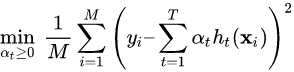

* 这里有T个个体学习器，每个学习器用 ht 表示，而αt就是对应的权重。
<br>

* ***Blending的优点在于：***

    * 比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）
    * 避开了一个信息泄露问题：generlizers和stacker使用了不一样的数据集
    * 在团队建模过程中，不需要给队友分享自己的随机种子

<br>

* ***缺点：***

    * 使用了很少的数据
    * blender可能会过拟合（其实大概率是第一点导致的）
    * stacking使用多次的CV会比较稳健

In [ ]:
def blend(train,test,target):
    '''5折'''
    # n_flods = 5
    # skf = list(StratifiedKFold(y, n_folds=n_flods))
    '''切分训练数据集为d1,d2两部分'''
    X_d1, X_d2, y_d1, y_d2 = train_test_split(train, target, test_size=0.5, random_state=914)

    train_ = np.zeros((X_d2.shape[0],len(clfs*3)))
    test_ = np.zeros((test.shape[0],len(clfs*3)))

    for j,clf in enumerate(clfs):
        '''依次训练各个单模型'''
        # print(j, clf)
        '''使用第1个部分作为预测，第2部分来训练模型，获得其预测的输出作为第2部分的新特征。'''
        # X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
        X_d1fillna=X_d1.fillna(0)
        X_d2fillna = X_d2.fillna(0)

        X_predictfillna= test.fillna(0)

        clf.fit(X_d1fillna,y_d1)
        y_submission = clf.predict(X_d2fillna)
        y_test_submission = clf.predict(X_predictfillna)

        train_[:,j*3] = y_submission*y_submission
        '''对于测试集，直接用这k个模型的预测值作为新的特征。'''
        test_[:, j*3] = y_test_submission*y_test_submission

        train_[:, j+1] =(y_submission - y_submission.min()) /(y_submission.max() - y_submission.min())
        '''对于测试集，直接用这k个模型的预测值作为新的特征。'''
        y_test_submission = (y_test_submission - y_test_submission.min()) / \
                            (y_test_submission.max() - y_test_submission.min())
        test_[:, j+1] = y_test_submission

        train_[:, j+2] = np.log(y_submission)
        '''对于测试集，直接用这k个模型的预测值作为新的特征。'''
        y_test_submission =np.log(y_test_submission)
        test_[:, j+2] = y_test_submission



        # print("val auc Score: %f" % r2_score(y_predict, dataset_d2[:, j]))
        print('已完成第',j)

    train_.to_csv('./input/train_blending.csv', index=False)
    test_.to_csv('./input/test_blending.csv', index=False)

## Stacking

* Stacking相比Linear Blending来说，更加强大，然而也更容易过拟合。<br>

* Stacking做法和Linear Blending类似，首先从数据集中训练出初级学习器，然后”生成“一个新的数据集用于训练次级学习器。为了防止过拟合，采用K折交叉验证法求解。<br>

### stacking是一种分层模型集成框架。

* 以两层为例，第一层由多个基学习器组成，其输入为原始训练集，第二层的模型则是以第一层基学习器的输出作为训练集进行再训练，从而得到完整的stacking模型。<br>

* stacking两层模型都使用了全部的训练数据<br>

* ***第一层模型：***<br>

    首先数据有训练集和测试集两部分<br>

    1.对训练集进行五折交叉验证，把训练集划分为A，B两部分<br>

    2.对A部分进行训练，对B部分进行预测，得到a1，五折后则为a1，a2，a3，a4，a5，对他们合并，形成n行一列的数据<br>

    3.对测试集进行预测，会得到b1，b2，b3，b4，b5，将各部分相加取平均得到m行一列的数据<br>

    4.以上是一个模型，如果有三个模型，则可以得到A1,A2,A3,B1,B2,B3<br>

    5.在此之后，我们把A1,A2,A3并列合并得到一个n行三列的矩阵作为training data，B1,B2,B3并列合并得到一个m行三列的矩阵作为testing data。让下一层的模型，基于他们进一步训练。

In [2]:
#!pip install mlxtend

import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [Stacking Classifier]


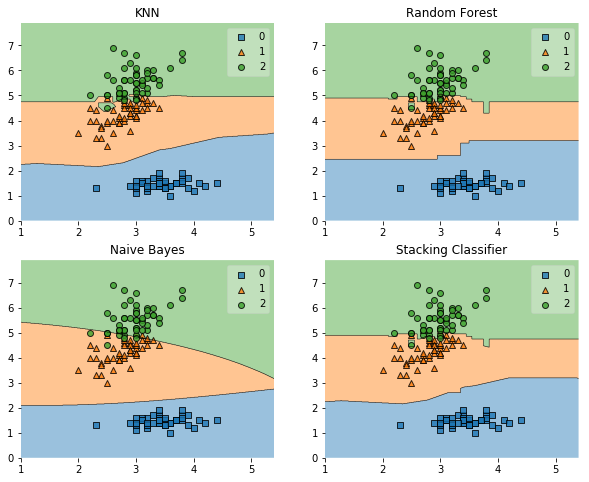

In [3]:
# 以python自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()